In [1]:
# Load images and labels
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

# # Define the input directory
input_dir = 'D:/ML_LOCAL_WIN/archive_dup_free'

# Initialize lists to store images and labels
images = []
labels = []

# Loop through each folder (class name) in the input directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        for file_name in os.listdir(category_path):
            if file_name.endswith('.jpeg') or file_name.endswith('.png'):  # Check for valid image files
                img_path = os.path.join(category_path, file_name)
                try:
                    # Open and preprocess the image
                    img = Image.open(img_path)
                    # img = img.resize((128, 128))  # Resize to 128x128
                    img_array = np.array(img)
                    
                    # Append the image and its label
                    images.append(img_array)
                    labels.append(category)  # Use the folder name as the label
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Print some information about the loaded data
print(f"Loaded {len(images)} images.")
print(f"Image shape: {images[0].shape} ")
print(f"Labels: {np.unique(labels)}")


Loaded 58514 images.
Image shape: (64, 64) 
Labels: ['AbdomenCT' 'BreastMRI' 'CXR' 'ChestCT' 'Hand' 'HeadCT']


In [2]:
from sklearn.model_selection import train_test_split

# Set random_state for reproducibility
random_state = 42

# Split into train and test only
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.3, random_state=random_state, stratify=labels
)

print(f"Shape Train set: {X_train.shape}, labels: {y_train.shape}")
print(f"Shape Test set: {X_test.shape}, labels:{y_test.shape}")

Shape Train set: (40959, 64, 64), labels: (40959,)
Shape Test set: (17555, 64, 64), labels:(17555,)


In [3]:
# LDA (Linear Discriminant Analysis) 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

# Flatten images for LDA
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_test_std = scaler.transform(X_test_flat)

# Number of LDA components (at most n_classes - 1)
n_classes = len(np.unique(y_train))
n_components = n_classes - 1

# Fit LDA on training data
lda = LinearDiscriminantAnalysis(n_components=n_components)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

print("LDA reduced train shape:", X_train_lda.shape)
print("LDA reduced test shape:", X_test_lda.shape)

LDA reduced train shape: (40959, 5)
LDA reduced test shape: (17555, 5)


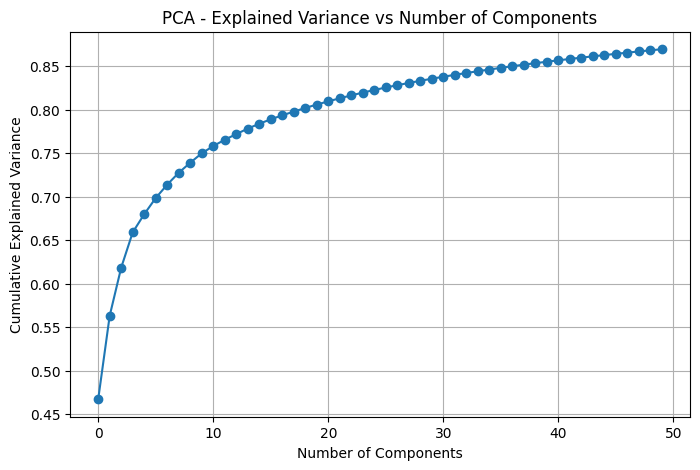

Original shape: (40959, 4096)
PCA reduced shape: (40959, 50)


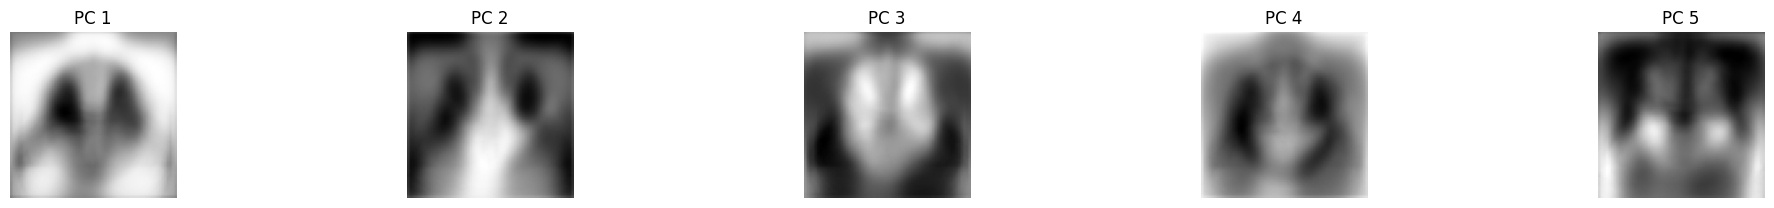

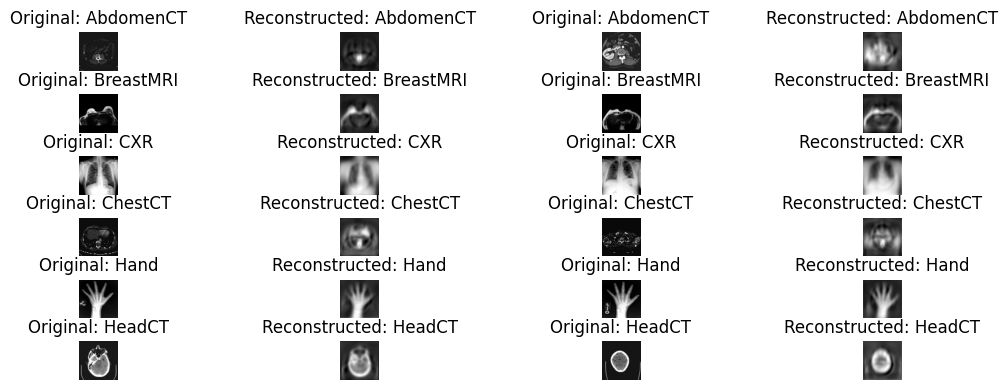

In [4]:
# PCA and visualization

import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



# Flatten images for PCA
num_samples = X_train.shape[0]
flattened_images = X_train.reshape(num_samples, -1)

# Standardize
scaler = StandardScaler()
flattened_images_std = scaler.fit_transform(flattened_images)

# Apply PCA
# If you apply PCA on the whole data (including the test data) before training the model,
# then you in fact use some information from the test data.
# Thus, you cannot really judge the behaviour of your model using the test data,
# because it is not an unseen data anymore.
n_components = 50
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(flattened_images_std)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

print(f"Original shape: {flattened_images.shape}")
print(f"PCA reduced shape: {principal_components.shape}")

# Plot the first 5 principal components
plt.figure(figsize=(20, 4))
for i in range(5):     
    plt.subplot(2, 5, i + 1)
    component = pca.components_[i].reshape(X_train[0].shape)
    plt.imshow(component, cmap='gray')
    plt.title(f'PC {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()
# Plot the first 5 images of the training set
# Inverse transform to reconstruct images from PCA
reconstructed = pca.inverse_transform(principal_components)
reconstructed_images = scaler.inverse_transform(reconstructed)
reconstructed_images = reconstructed_images.reshape(X_train.shape)

# Plot 2 images per class: original vs reconstructed
unique_classes = np.unique(y_train)
images_per_class = 2

plt.figure(figsize=(10, 4))  # Bigger images

plot_idx = 1
for class_label in unique_classes:
    # Find indices for this class
    class_indices = np.where(y_train == class_label)[0][:images_per_class]
    for i, idx in enumerate(class_indices):
        plt.subplot(len(unique_classes), images_per_class * 2, plot_idx)
        plt.imshow(X_train[idx], cmap='gray')
        plt.title(f"Original: {class_label}")
        plt.axis('off')
        plot_idx += 1

        plt.subplot(len(unique_classes), images_per_class * 2, plot_idx)
        plt.imshow(reconstructed_images[idx], cmap='gray')
        plt.title(f"Reconstructed: {class_label}")
        plt.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

In [5]:
# # T-sne only useful for visualization

# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# import numpy as np

# # Flatten and standardize the training images
# num_samples = X_train.shape[0]
# flattened_images = X_train.reshape(num_samples, -1)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# flattened_images_std = scaler.fit_transform(flattened_images)

# # Apply t-SNE
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# X_tsne = tsne.fit_transform(flattened_images_std)
# print("t-SNE output shape:", X_tsne.shape)

# # Plot t-SNE result, colored by class
# plt.figure(figsize=(10, 7))
# for class_label in np.unique(y_train):
#     idx = np.where(y_train == class_label)
#     plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=class_label, s=15)
# plt.title("t-SNE Visualization of Training Data")
# plt.xlabel("t-SNE 1")
# plt.ylabel("t-SNE 2")
# plt.legend()
# plt.show()

In [6]:
# Logistic regression whithot PCA

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Flatten images for classification
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_test_std = scaler.transform(X_test_flat)

# Train logistic regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_std, y_train)

# Predict on test set
y_pred = clf.predict(X_test_std)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.9918541726003988

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.99      1.00      1.00      2897
   BreastMRI       1.00      1.00      1.00      2686
         CXR       0.99      0.99      0.99      3000
     ChestCT       0.99      1.00      1.00      3000
        Hand       0.99      0.97      0.98      3000
      HeadCT       0.99      0.99      0.99      2972

    accuracy                           0.99     17555
   macro avg       0.99      0.99      0.99     17555
weighted avg       0.99      0.99      0.99     17555



In [7]:
# just checkig 
num_samples = X_train.shape[0]
print(f"Number of samples: {num_samples}")
print("---------------------------------------")
flattened_images = X_train.reshape(num_samples, -1)
print(f"Flattened images shape: {flattened_images.shape}")
print("---------------------------------------")
print("pricipal components shape: ", principal_components.shape)
print("---------------------------------------")   
print("principal components=",principal_components)

Number of samples: 40959
---------------------------------------
Flattened images shape: (40959, 4096)
---------------------------------------
pricipal components shape:  (40959, 50)
---------------------------------------
principal components= [[-41.45849844  28.19210053   9.11771446 ...  -2.75786941  -2.13311846
   -5.05734756]
 [ 44.31073038 -19.35788509   7.68045981 ...   0.52938388   0.83647143
    0.62188407]
 [ 43.36093019 -20.12242721   4.66127181 ...  -0.19923896  -0.60438231
    0.11235305]
 ...
 [  0.56294095  17.23246022  21.73856665 ...   0.34283562   4.63419713
    0.49428028]
 [ 19.48234785  32.64926868   3.21541716 ...  -4.7803032    1.52200137
   -0.9976636 ]
 [-64.94485291 -15.25872959 -17.16608154 ...  -0.52069446   1.86973703
   -2.90869968]]


In [8]:
# Logistic regreression which uses PCA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Flatten and standardize validation and test sets using the same scaler as training
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_test_std = scaler.transform(X_test_flat)

# Apply PCA transformation using the same PCA fitted on training data
X_test_pca = pca.transform(X_test_std)

# Use PCA-reduced features for training
X_train_pca = principal_components  # Already computed for training set

# Train multiclass logistic regression classifier
clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
clf.fit(X_train_pca, y_train)

# Predict on test set
y_pred = clf.predict(X_test_pca)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

d:\ML_LOCAL_WIN\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Accuracy: 0.9939618342352606

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00      2897
   BreastMRI       1.00      1.00      1.00      2686
         CXR       1.00      0.99      0.99      3000
     ChestCT       1.00      1.00      1.00      3000
        Hand       0.99      0.98      0.99      3000
      HeadCT       0.99      1.00      0.99      2972

    accuracy                           0.99     17555
   macro avg       0.99      0.99      0.99     17555
weighted avg       0.99      0.99      0.99     17555



Confusion Matrix:
 [[2897    0    0    0    0    0]
 [   0 2686    0    0    0    0]
 [   3    2 2968    9   13    5]
 [   0    0    0 3000    0    0]
 [   9    2   13    6 2937   33]
 [   1    0    1    0    9 2961]]


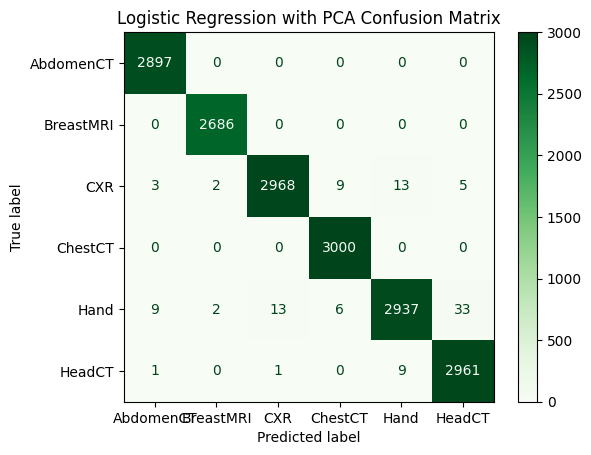

Accuracy: 0.9940
Precision (macro): 0.9940
Recall (macro): 0.9941
F1 Score (macro): 0.9941

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00      2897
   BreastMRI       1.00      1.00      1.00      2686
         CXR       1.00      0.99      0.99      3000
     ChestCT       1.00      1.00      1.00      3000
        Hand       0.99      0.98      0.99      3000
      HeadCT       0.99      1.00      0.99      2972

    accuracy                           0.99     17555
   macro avg       0.99      0.99      0.99     17555
weighted avg       0.99      0.99      0.99     17555



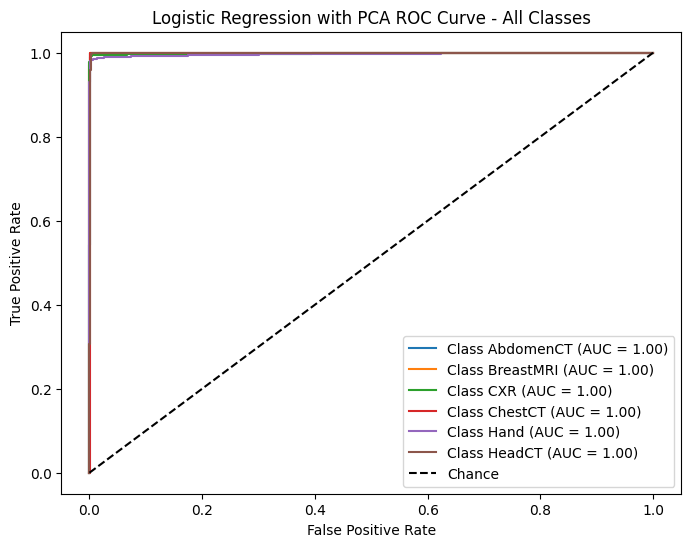

In [9]:
# Assess the model's performance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,
    recall_score, f1_score, classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

def assess_model_performance(clf, X_test, y_test, class_labels=None, title_prefix=""):
    """
    Assess and visualize the performance of a classifier.
    
    Parameters:
        clf: Trained classifier
        X_test: Test features
        y_test: True test labels
        class_labels: List of class labels (optional)
        title_prefix: String to prefix plot titles (optional)
    """
    # Predict
    y_pred = clf.predict(X_test)
    if class_labels is None:
        class_labels = np.unique(y_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    print("Confusion Matrix:\n", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Greens)
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    # Accuracy, Precision, Recall, F1
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision (macro): {prec:.4f}")
    print(f"Recall (macro): {rec:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")

    # Classification Report
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

    # ROC Curve (if possible)
    y_score = None
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)
    elif hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)

    if y_score is not None:
        y_test_bin = label_binarize(y_test, classes=class_labels)
        plt.figure(figsize=(8, 6))
        for i, class_label in enumerate(class_labels):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{title_prefix} ROC Curve - All Classes')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("ROC curve and AUC not available for this classifier.")

# Assess the model's performance
assess_model_performance(clf, X_test_pca, y_test, class_labels=np.unique(y_train), title_prefix="Logistic Regression with PCA")

d:\ML_LOCAL_WIN\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


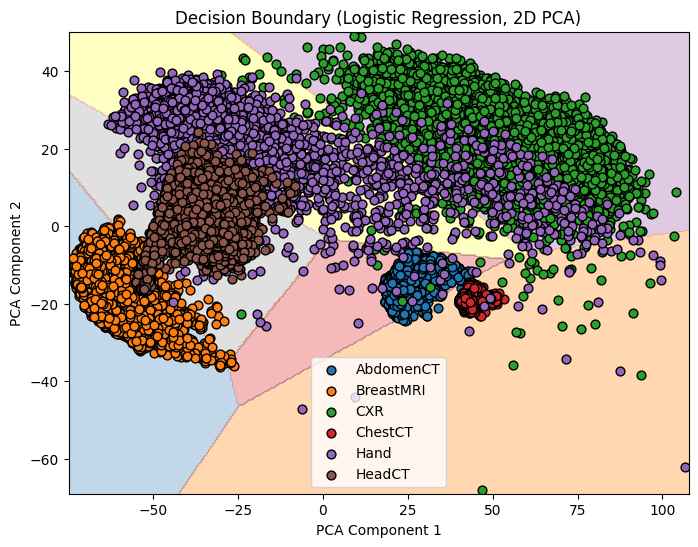

In [10]:
# Plotting decision boundary using the first two PCA components
import numpy as np
import matplotlib.pyplot as plt

# Reduce data to 2D for visualization
X_train_2d = X_train_pca[:, :2]
X_test_2d = X_test_pca[:, :2]

# Retrain classifier on 2D PCA data for visualization
clf_2d = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
clf_2d.fit(X_train_2d, y_train)

# Create a mesh to plot the decision boundary
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = clf_2d.predict(np.c_[xx.ravel(), yy.ravel()])

# Map class labels to integer indices for contourf
class_labels, Z_int = np.unique(y_train, return_inverse=True)
label_to_int = {label: idx for idx, label in enumerate(class_labels)}
Z_int = np.array([label_to_int[label] for label in Z])
Z_int = Z_int.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_int, alpha=0.3, cmap=plt.cm.Set1)

# Plot training points
for class_label in np.unique(y_train):
    idx = np.where(y_train == class_label)
    plt.scatter(X_train_2d[idx, 0], X_train_2d[idx, 1], label=class_label, edgecolor='k', s=40)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary (Logistic Regression, 2D PCA)')
plt.legend()
plt.show()

In [11]:
# Grid search for best hyperparameters in Logistic Regression with PCA features

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid
param_grid = {
    'C': np.logspace(-4,4,20),
    'solver': ['lbfgs', 'saga'],
    'multi_class': ['multinomial'],
    'max_iter': [100,1000,2500, 5000]
}

# Initialize Logistic Regression (no need to set random_state for grid search)
logreg = LogisticRegression()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-reduced training data
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_pca)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 160 candidates, totalling 480 fits


KeyboardInterrupt: 

Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 2  0 43  0]
 [ 0  0  0 45]]


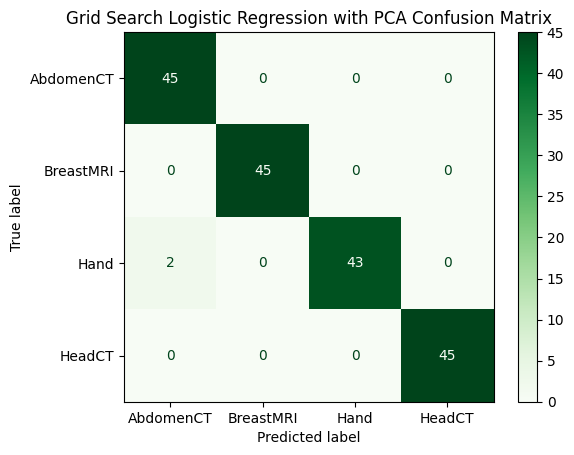

Accuracy: 0.9889
Precision (macro): 0.9894
Recall (macro): 0.9889
F1 Score (macro): 0.9889

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.96      1.00      0.98        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.96      0.98        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



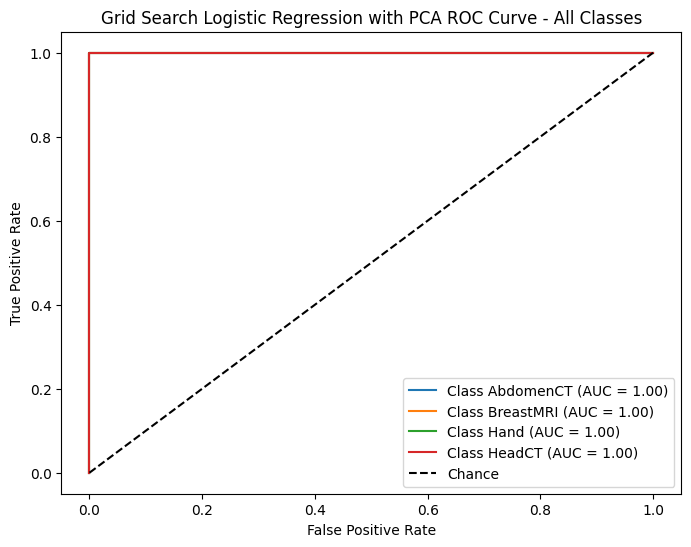

In [ ]:
# assess_model_performance(grid_search.best_estimator_, X_test_pca, y_test)
assess_model_performance(grid_search.best_estimator_, X_test_pca, y_test, class_labels=np.unique(y_train), title_prefix="Grid Search Logistic Regression with PCA")

In [ ]:
# Logistic regreression which uses LDA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


# Train multiclass logistic regression classifier
clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
clf.fit(X_train_lda, y_train)

# Predict on test set
y_pred = clf.predict(X_test_lda)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.9833333333333333

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.93      0.97        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



d:\ML_LOCAL_WIN\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 3  0 42  0]
 [ 0  0  0 45]]


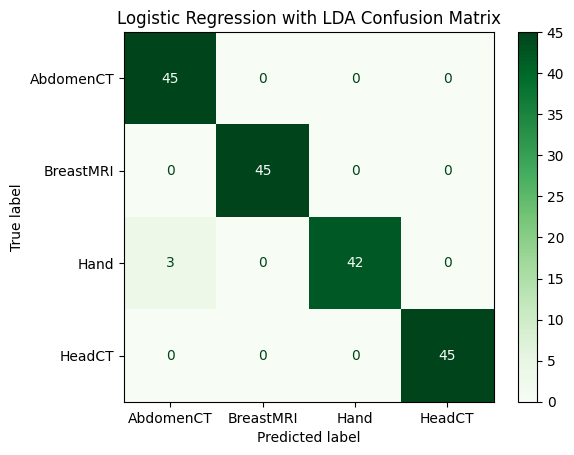

Accuracy: 0.9833
Precision (macro): 0.9844
Recall (macro): 0.9833
F1 Score (macro): 0.9833

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.93      0.97        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



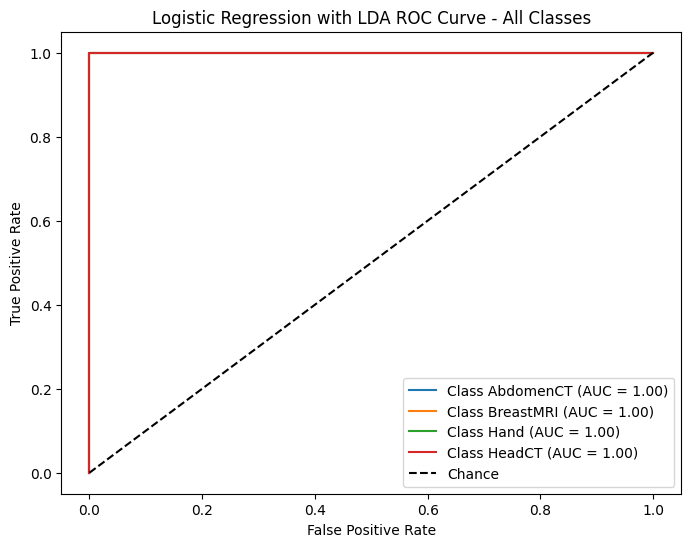

In [ ]:
assess_model_performance(clf, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="Logistic Regression with LDA")

In [ ]:
# Grid search for best hyperparameters in Logistic Regression with LDA features

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid
param_grid = {
    'C': np.logspace(-4, 4, 20),
    'solver': ['lbfgs', 'saga'],
    'multi_class': ['multinomial'],
    'max_iter': [100, 1000, 2500, 5000]
}

# Initialize Logistic Regression
logreg = LogisticRegression()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on LDA-reduced training data
grid_search.fit(X_train_lda, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_lda)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# not much change in the performance of the model
#  and for that reason will not do plots

Fitting 3 folds for each of 160 candidates, totalling 480 fits
Best parameters found: {'C': np.float64(0.0001), 'max_iter': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Best cross-validation score: 1.0
Test Accuracy: 0.9833333333333333

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.93      0.97        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



d:\ML_LOCAL_WIN\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 3  0 42  0]
 [ 0  0  0 45]]


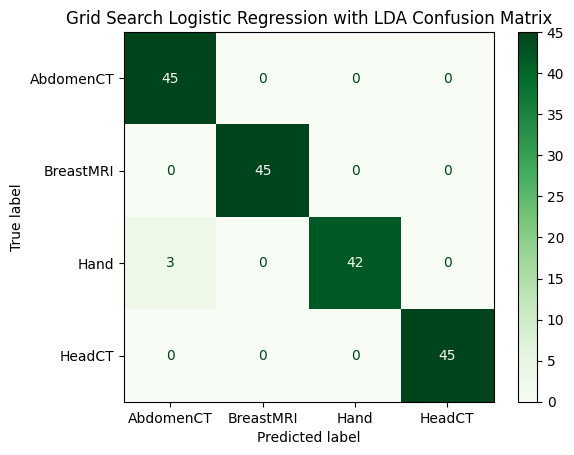

Accuracy: 0.9833
Precision (macro): 0.9844
Recall (macro): 0.9833
F1 Score (macro): 0.9833

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.93      0.97        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



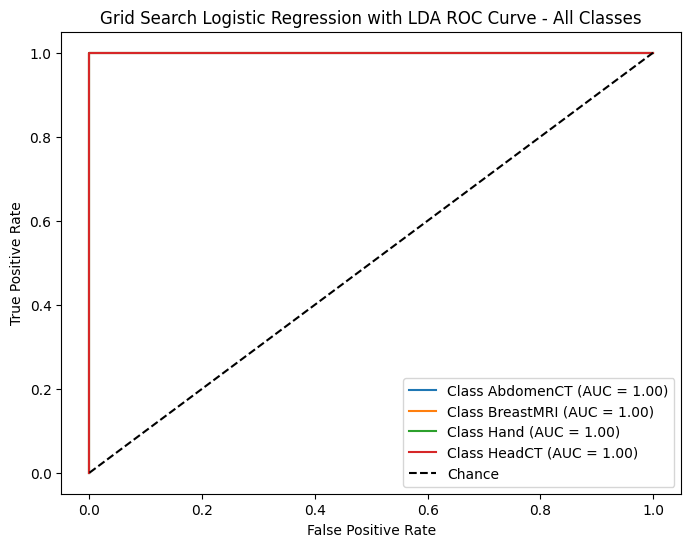

In [ ]:
assess_model_performance(grid_search.best_estimator_, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="Grid Search Logistic Regression with LDA")

In [ ]:
# Classification SVM without PCA

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Flatten images for classification
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_test_std = scaler.transform(X_test_flat)

# Train SVM on PCA-reduced features
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_std, y_train)

# Predict on test set
y_pred = svm_clf.predict(X_test_std)

# Evaluate
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

SVM Test Accuracy: 1.0

SVM Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      1.00      1.00        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



In [ ]:
# Classification SVM with PCA

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train SVM on PCA-reduced features
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_pca, y_train)

# Predict on test set
y_pred = svm_clf.predict(X_test_pca)

# Evaluate
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

SVM Test Accuracy: 0.9944444444444445

SVM Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.98      0.99        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 0  0 44  1]
 [ 0  0  0 45]]


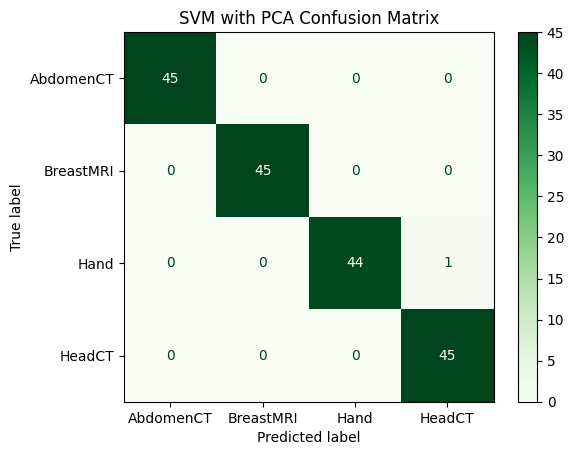

Accuracy: 0.9944
Precision (macro): 0.9946
Recall (macro): 0.9944
F1 Score (macro): 0.9944

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.98      0.99        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



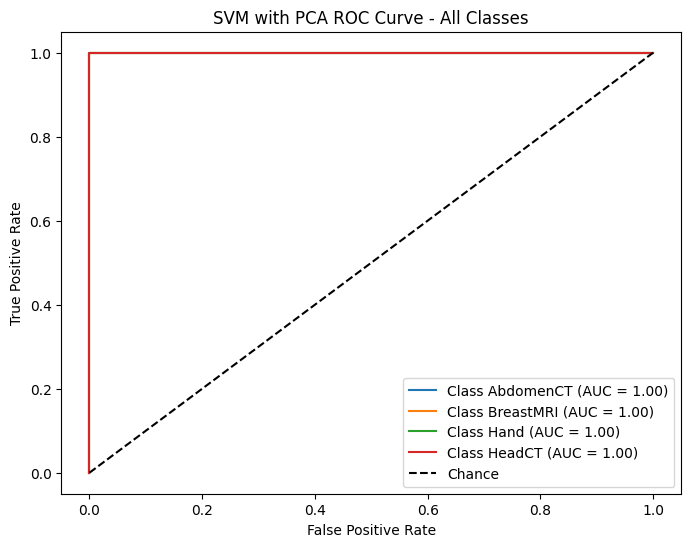

In [ ]:
assess_model_performance(svm_clf, X_test_pca, y_test, class_labels=np.unique(y_train), title_prefix="SVM with PCA")

In [ ]:
# Grid search for best hyperparameters in SVM with PCA features

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 0.0001, 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Initialize SVM classifier
svm = SVC()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-reduced training data
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_pca)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found: {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
Best cross-validation score: 1.0
SVM Test Accuracy: 1.0

SVM Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      1.00      1.00        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 0  0 45  0]
 [ 0  0  0 45]]


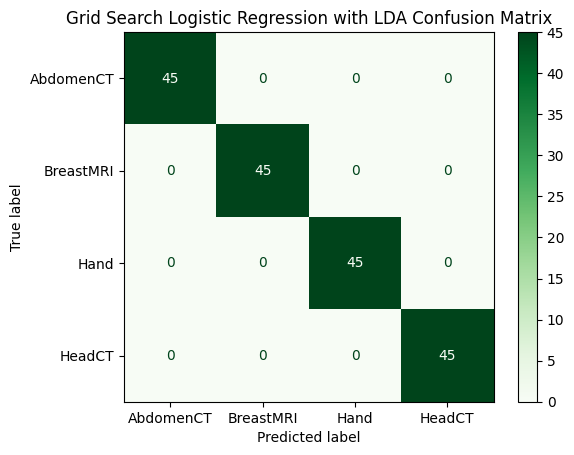

Accuracy: 1.0000
Precision (macro): 1.0000
Recall (macro): 1.0000
F1 Score (macro): 1.0000

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      1.00      1.00        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



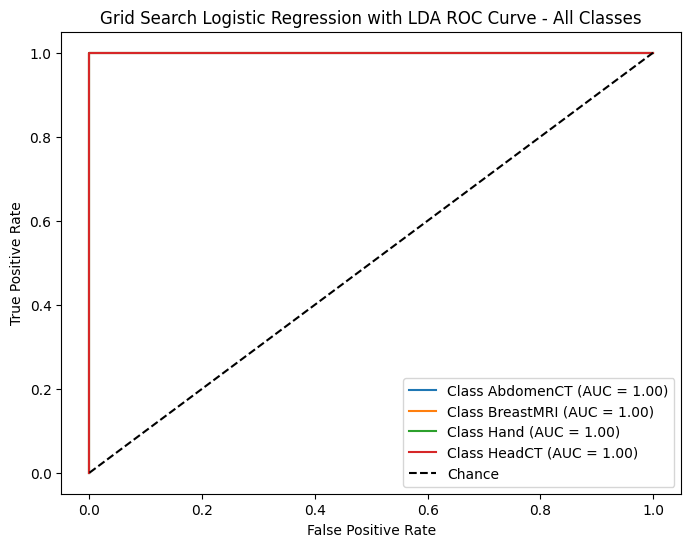

In [ ]:
assess_model_performance(grid_search.best_estimator_, X_test_pca, y_test, class_labels=np.unique(y_train), title_prefix="Grid Search Logistic Regression with LDA")

In [ ]:
# Classification SVM with LDA

from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Train SVM on PCA-reduced features
svm_clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_clf.fit(X_train_lda, y_train)

# Predict on test set
y_pred = svm_clf.predict(X_test_lda)

# Evaluate
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

SVM Test Accuracy: 0.9777777777777777

SVM Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.91      0.95        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 3  0 41  1]
 [ 0  0  0 45]]


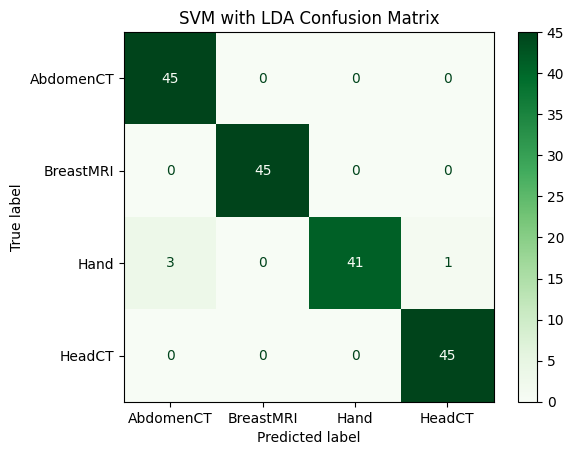

Accuracy: 0.9778
Precision (macro): 0.9789
Recall (macro): 0.9778
F1 Score (macro): 0.9776

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.91      0.95        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



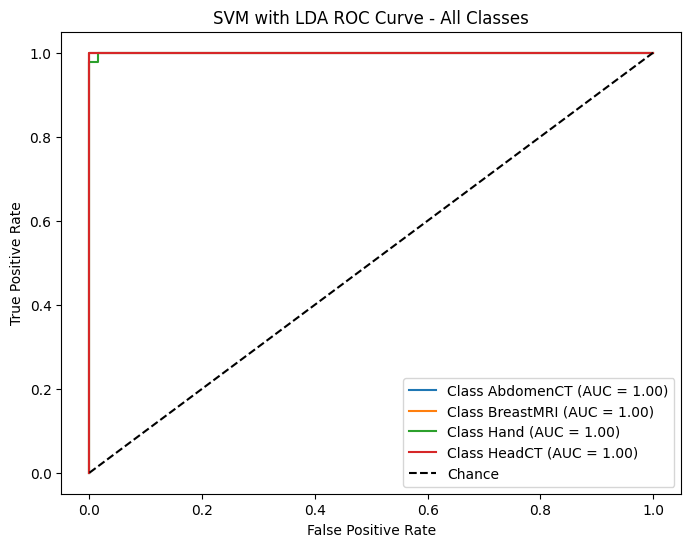

In [ ]:
assess_model_performance(svm_clf, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="SVM with LDA")

In [ ]:
# Grid search for best hyperparameters in SVM with LDA features

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# Initialize SVM classifier
svm = SVC()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on LDA-reduced training data
grid_search.fit(X_train_lda, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_lda)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best parameters found: {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
Best cross-validation score: 1.0
SVM Test Accuracy: 0.9833333333333333

SVM Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.93      0.97        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 3  0 42  0]
 [ 0  0  0 45]]


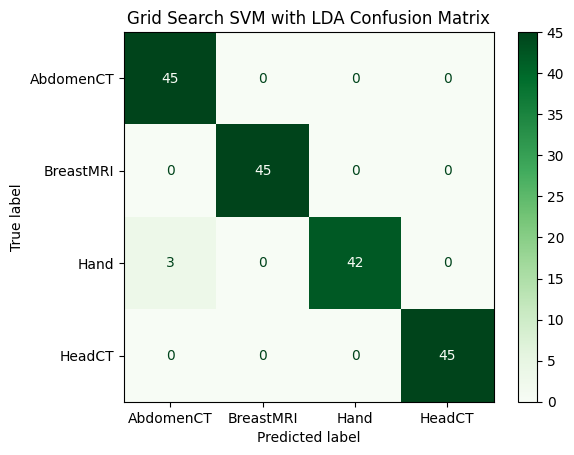

Accuracy: 0.9833
Precision (macro): 0.9844
Recall (macro): 0.9833
F1 Score (macro): 0.9833

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.93      0.97        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



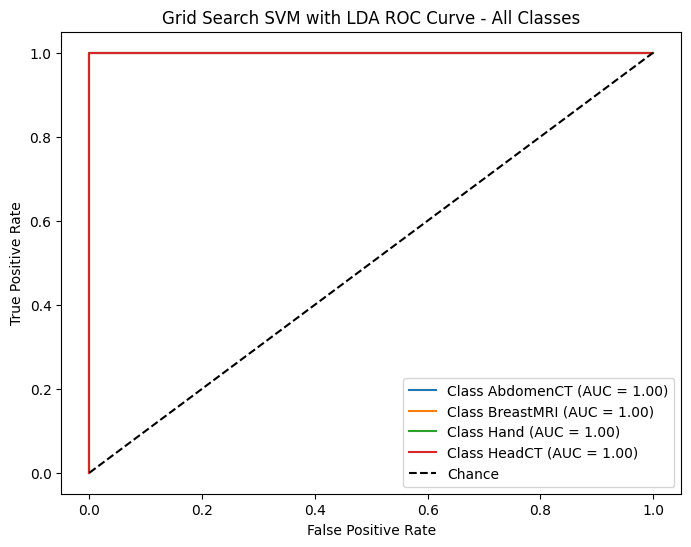

In [ ]:
assess_model_performance(grid_search.best_estimator_, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="Grid Search SVM with LDA")

In [ ]:
# KNN classification without PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Flatten images for classification
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_test_std = scaler.transform(X_test_flat)

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
knn.fit(X_train_std, y_train)

# Predict on test set
y_pred = knn.predict(X_test_std)

# Evaluate
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

KNN Test Accuracy: 0.9722222222222222

KNN Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.92      1.00      0.96        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.89      0.94        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



In [ ]:
# KNN classification with PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Use PCA-reduced features for training and testing
# X_train_pca, X_test_pca, y_train, y_test should already be defined

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
knn.fit(X_train_pca, y_train)

# Predict on test set
y_pred = knn.predict(X_test_pca)

# Evaluate
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

KNN Test Accuracy: 0.9722222222222222

KNN Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.92      1.00      0.96        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.89      0.94        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 4  0 40  1]
 [ 0  0  0 45]]


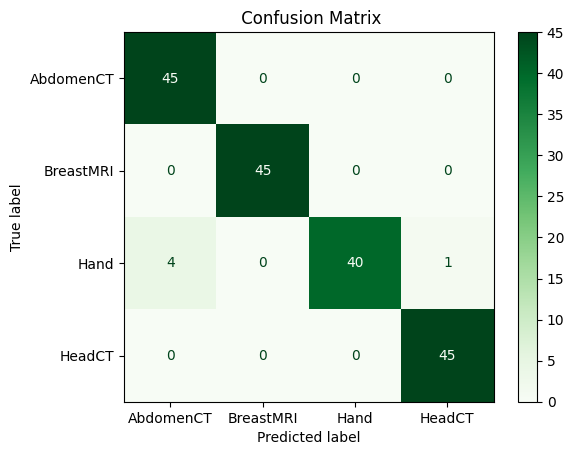

Accuracy: 0.9722
Precision (macro): 0.9742
Recall (macro): 0.9722
F1 Score (macro): 0.9719

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.92      1.00      0.96        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.89      0.94        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



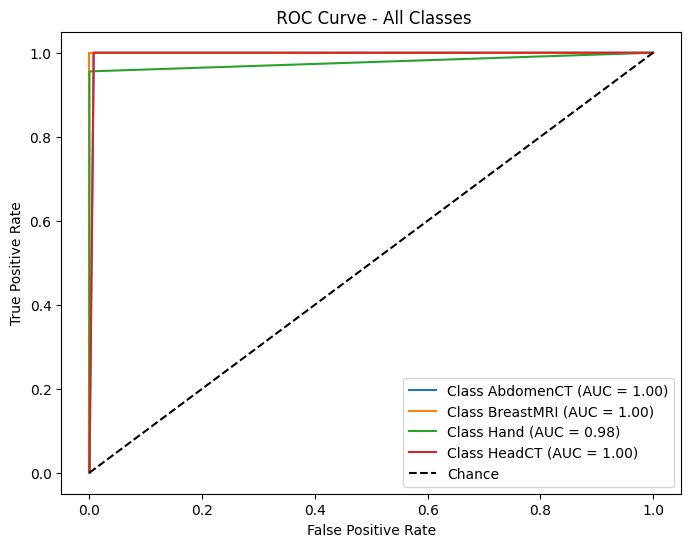

In [ ]:
assess_model_performance(knn, X_test_pca, y_test)

In [ ]:
# Grid search for best hyperparameters in KNN with PCA features

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define parameter grid for KNN
param_grid = {
    'n_neighbors': np.arange(2, 30, 1),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize KNN classifier
knn = KNeighborsClassifier()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)


# Fit on PCA-reduced training data
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_pca)
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 112 candidates, totalling 336 fits
Best parameters found: {'metric': 'manhattan', 'n_neighbors': np.int64(2), 'weights': 'distance'}
Best cross-validation score: 0.9952380952380953
KNN Test Accuracy: 0.9833333333333333

KNN Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.96      1.00      0.98        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.93      0.97        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



d:\ML_LOCAL_WIN\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.98571429 0.99285714 0.98809524 0.98809524 0.98333333 0.98809524
 0.98333333 0.98571429 0.97857143 0.98333333 0.97380952 0.97619048
 0.97380952 0.97380952 0.97142857 0.97142857 0.97142857 0.97142857
 0.97142857 0.97142857 0.97142857 0.97142857 0.96904762 0.96904762
 0.96904762 0.96904762 0.96666667 0.96666667 0.96428571 0.96666667
 0.96428571 0.96666667 0.96428571 0.96666667 0.96428571 0.96666667
 0.96428571 0.96666667 0.96428571 0.96666667 0.96428571 0.96428571
 0.96428571 0.96428571 0.96428571 0.96428571 0.96428571 0.96428571
 0.96428571 0.96428571 0.96428571 0.96428571 0.96428571 0.96428571
 0.96428571 0.96428571        nan 0.9952381         nan 0.98333333
        nan 0.98095238        nan 0.97857143        nan 0.97857143
        nan 0.97857143        nan 0.97857143        nan 0.97380952
        nan 0.97619048        nan 0.97619048        nan

Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 2  0 42  1]
 [ 0  0  0 45]]


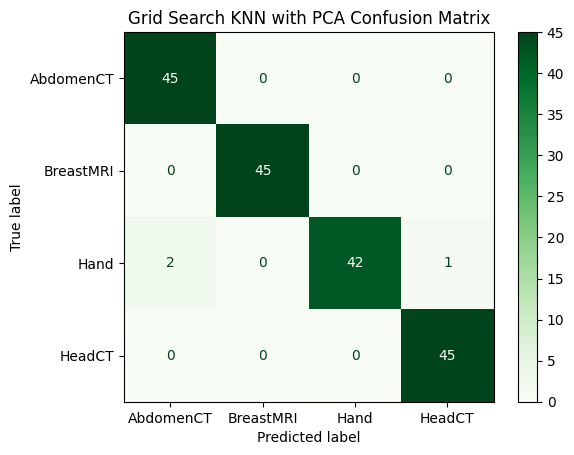

Accuracy: 0.9833
Precision (macro): 0.9839
Recall (macro): 0.9833
F1 Score (macro): 0.9832

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.96      1.00      0.98        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.93      0.97        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



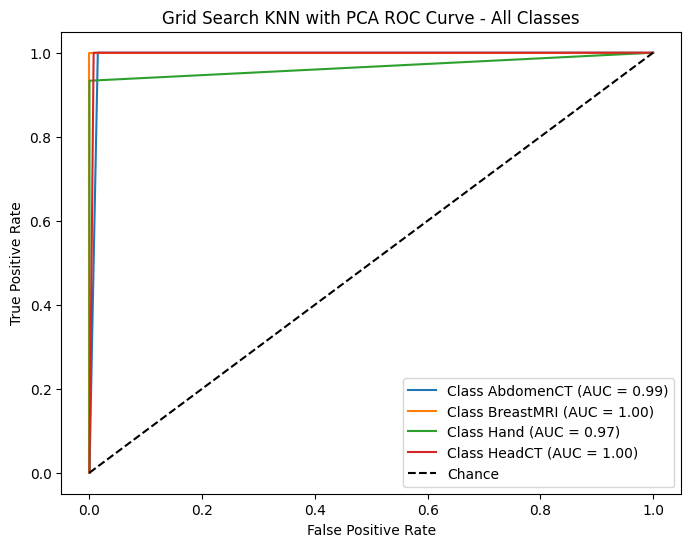

In [ ]:
assess_model_performance(grid_search.best_estimator_, X_test_pca, y_test, class_labels=np.unique(y_train), title_prefix="Grid Search KNN with PCA")

In [ ]:
#  custom KNN hyperparameter tuning
train_score = {}
test_score = {}
n_neighbors = np.arange(2, 30, 1)
for neighbor in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X_train_pca, y_train)
    train_score[neighbor]=knn.score(X_train_pca, y_train)
    test_score[neighbor]=knn.score(X_test_pca, y_test)


for key, value in test_score.items():
    if value==max(test_score.values()):
        best_no_neighbors = key
        print(best_no_neighbors)

# https://medium.com/@agrawalsam1997/hyperparameter-tuning-of-knn-classifier-a32f31af25c7

2
3


In [ ]:
# KNN classification with PCA and custom hyperparameter tuning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Use PCA-reduced features for training and testing
# X_train_pca, X_test_pca, y_train, y_test should already be defined

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=best_no_neighbors)  # You can adjust n_neighbors
knn.fit(X_train_pca, y_train)

# Predict on test set
y_pred = knn.predict(X_test_pca)

# Evaluate
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

KNN Test Accuracy: 0.9777777777777777

KNN Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.91      0.95        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



In [ ]:
# KNN classification with LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
knn.fit(X_train_lda, y_train)

# Predict on test set
y_pred = knn.predict(X_test_lda)

# Evaluate
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

KNN Test Accuracy: 0.9777777777777777

KNN Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.91      0.95        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



In [ ]:
# Grid search for best hyperparameters in KNN with LDA features

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid for KNN
param_grid = {
    'n_neighbors': np.arange(2, 30, 1),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize KNN classifier
knn = KNeighborsClassifier()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on LDA-reduced training data
grid_search.fit(X_train_lda, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_lda)
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nKNN Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 112 candidates, totalling 336 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': np.int64(2), 'weights': 'uniform'}
Best cross-validation score: 1.0
KNN Test Accuracy: 0.9777777777777777

KNN Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.91      0.95        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 3  0 41  1]
 [ 0  0  0 45]]


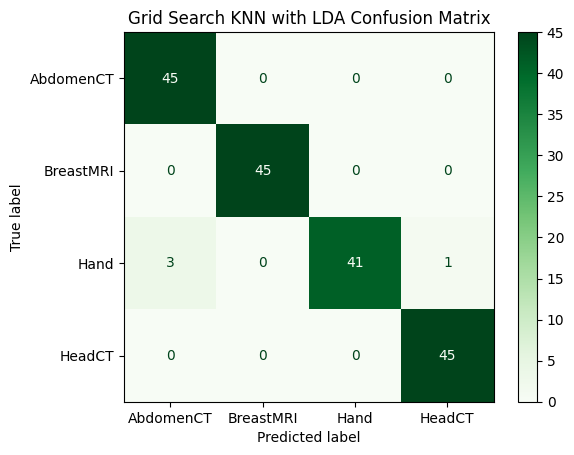

Accuracy: 0.9778
Precision (macro): 0.9789
Recall (macro): 0.9778
F1 Score (macro): 0.9776

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.91      0.95        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



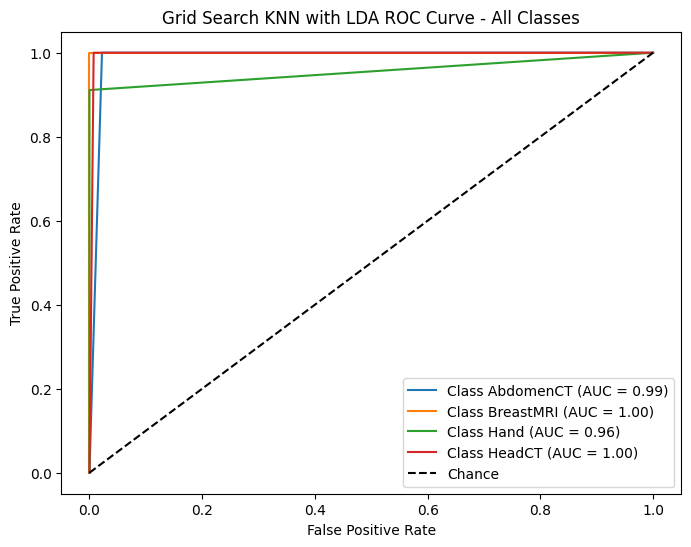

In [ ]:
assess_model_performance(grid_search.best_estimator_, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="Grid Search KNN with LDA")

In [ ]:
# Naive Bayes classification without PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Flatten images for classification
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_test_std = scaler.transform(X_test_flat)

# Train Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(X_train_std, y_train)

# Predict on test set
y_pred = nb_clf.predict(X_test_std)

# Evaluate
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

Naive Bayes Test Accuracy: 0.9833333333333333

Naive Bayes Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        45
   BreastMRI       1.00      0.98      0.99        45
        Hand       0.94      1.00      0.97        45
      HeadCT       1.00      0.96      0.98        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



In [ ]:
# Naive Bayes classification with PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Train Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(X_train_pca, y_train)

# Predict on test set
y_pred = nb_clf.predict(X_test_pca)

# Evaluate
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

Naive Bayes Test Accuracy: 1.0

Naive Bayes Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      1.00      1.00        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 0  0 45  0]
 [ 0  0  0 45]]


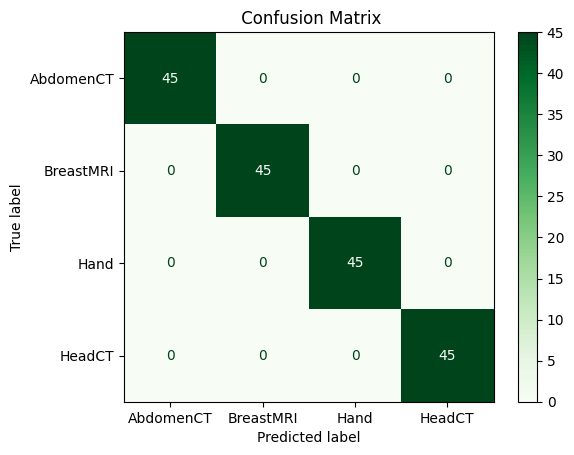

Accuracy: 1.0000
Precision (macro): 1.0000
Recall (macro): 1.0000
F1 Score (macro): 1.0000

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      1.00      1.00        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



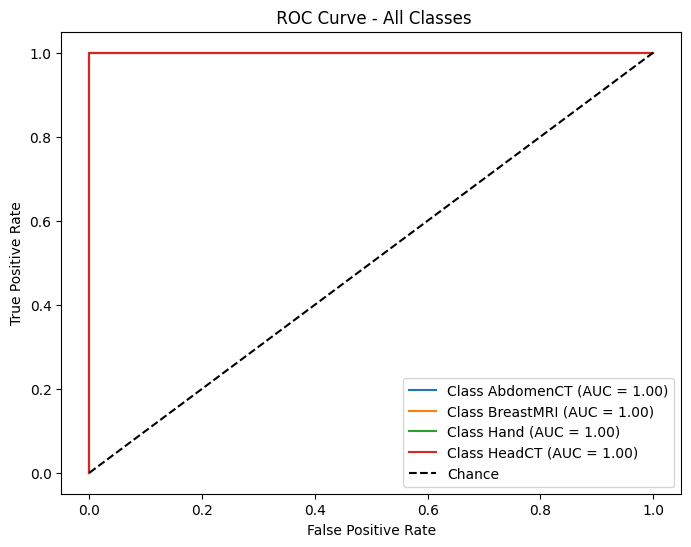

In [ ]:
assess_model_performance(nb_clf, X_test_pca, y_test)

In [ ]:
# Grid search for best hyperparameters in Naive Bayes with PCA features

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid for GaussianNB
param_grid = {
    'var_smoothing': np.logspace(0, -50, 10)  # Typical range for var_smoothing
}

# Initialize GaussianNB classifier
nb = GaussianNB()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=nb,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-reduced training data
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_pca)
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'var_smoothing': np.float64(2.782559402207126e-06)}
Best cross-validation score: 1.0
Naive Bayes Test Accuracy: 1.0

Naive Bayes Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       1.00      1.00      1.00        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      1.00      1.00        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



In [ ]:
# Naive Bayes classification with LDA

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Train Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(X_train_lda, y_train)

# Predict on test set
y_pred = nb_clf.predict(X_test_lda)

# Get parameters
print("Naive Bayes Classifier Parameters:", nb_clf.get_params())

# Evaluate
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

Naive Bayes Classifier Parameters: {'priors': None, 'var_smoothing': 1e-09}
Naive Bayes Test Accuracy: 0.9666666666666667

Naive Bayes Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.92      1.00      0.96        45
   BreastMRI       0.98      1.00      0.99        45
        Hand       1.00      0.87      0.93        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 4  1 39  1]
 [ 0  0  0 45]]


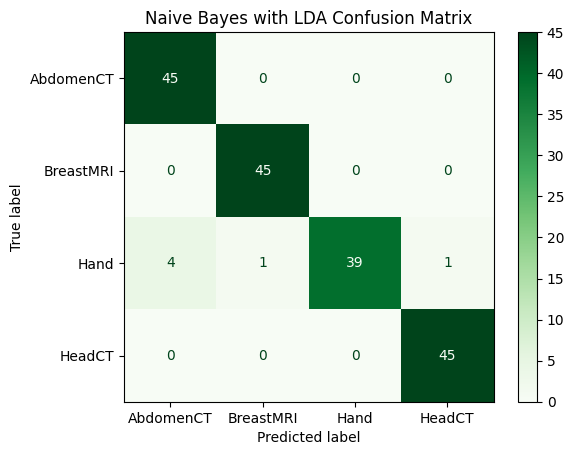

Accuracy: 0.9667
Precision (macro): 0.9687
Recall (macro): 0.9667
F1 Score (macro): 0.9660

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.92      1.00      0.96        45
   BreastMRI       0.98      1.00      0.99        45
        Hand       1.00      0.87      0.93        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



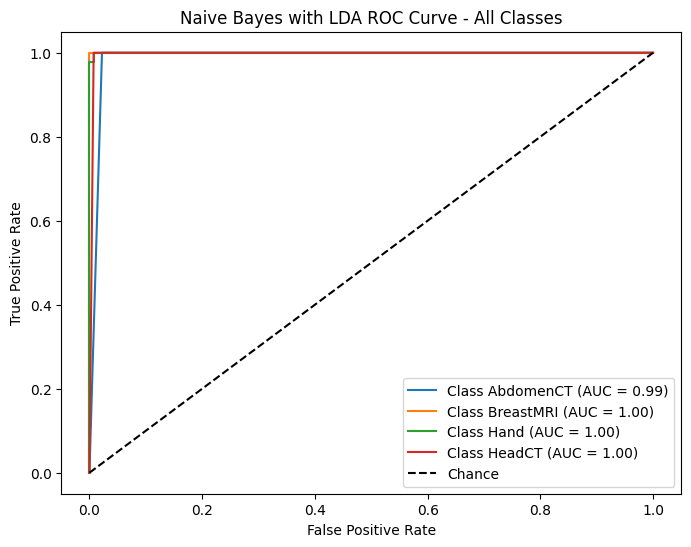

In [ ]:
assess_model_performance(nb_clf, X_test_lda, y_test, class_labels=np.unique(y_train), title_prefix="Naive Bayes with LDA")

In [ ]:
# Grid search for best hyperparameters in Naive Bayes with LDA features

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid for GaussianNB
param_grid = {
    'var_smoothing': np.logspace(0, -9, 100)  # Typical range for var_smoothing
}

# Initialize GaussianNB classifier
nb = GaussianNB()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=nb,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-reduced training data
grid_search.fit(X_train_lda, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_lda)
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found: {'var_smoothing': np.float64(1.0)}
Best cross-validation score: 1.0
Naive Bayes Test Accuracy: 0.9777777777777777

Naive Bayes Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.91      0.95        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



---------------------------------------------------
GaussianNB(var_smoothing=np.float64(1.0))
{'var_smoothing': np.float64(1.0)}
---------------------------------------------------
Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 3  0 41  1]
 [ 0  0  0 45]]


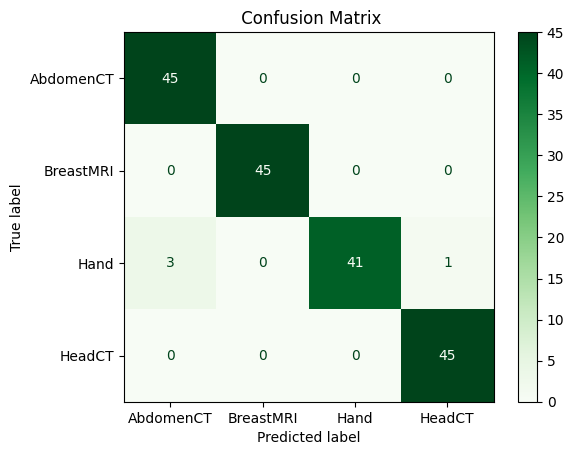

Accuracy: 0.9778
Precision (macro): 0.9789
Recall (macro): 0.9778
F1 Score (macro): 0.9776

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.94      1.00      0.97        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.91      0.95        45
      HeadCT       0.98      1.00      0.99        45

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



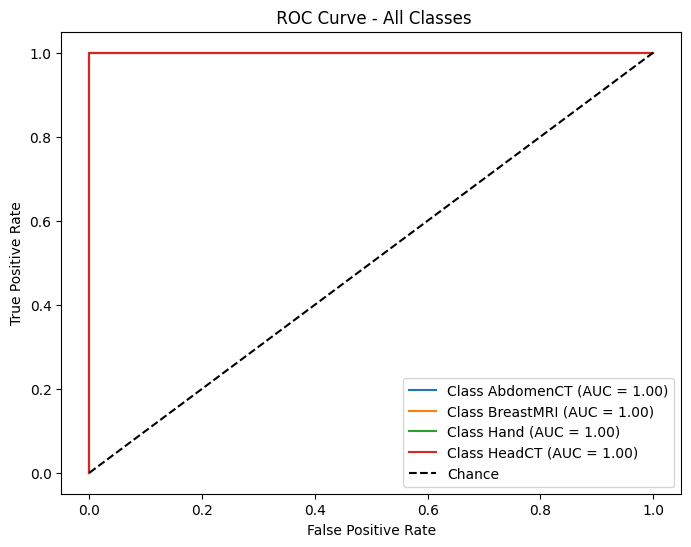

In [ ]:
assess_model_performance(grid_search.best_estimator_, X_test_lda, y_test)